## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [127]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from PIL import Image

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [128]:
# Opening JSON file 
f = open('complaints.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [129]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [130]:
# Setting limits for dataframe columns and column width
pd.options.display.max_columns = 22
pd.options.display.max_colwidth = 2000

In [131]:
# Let's have a look at the dataframe
df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided


In [132]:
#print the column names
print(list(df.columns))

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [133]:
#Assign new column names
# Removing '_' and 'source.' from the column names
df.columns = [re.sub('^_','',cols) for cols in df.columns]
df.columns = [re.sub('source.','',cols) for cols in df.columns]

In [134]:
# Checking updated column names
print(list(df.columns))

['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [135]:
# Checking the dataframe
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided


In [136]:
# Checking null values for complaint column in the dataset
col_null = [['Non-null',round(len(df[df['complaint_what_happened'] != ''])/len(df),2)],['Null',round(len(df[df['complaint_what_happened'] == ''])/len(df),2)]]
df_rep = pd.DataFrame(col_null,columns = ['Column_values','Percentage'])
print(df_rep)

  Column_values  Percentage
0      Non-null        0.27
1          Null        0.73


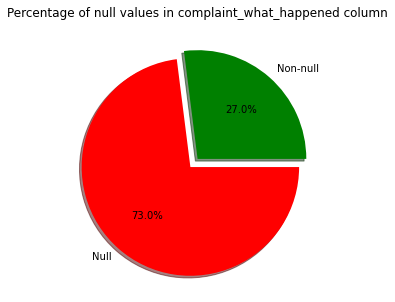

In [137]:
# Graph showing the total aount of investment in the four investment types
plt.figure(figsize=[5,5])
colors = ['green','red']
explode =(0,0.1) 
plt.pie(df_rep['Percentage'],labels=df_rep['Column_values'],explode = explode, shadow=True, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of null values in complaint_what_happened column')
plt.show()

In [138]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened = df['complaint_what_happened'].replace('',np.nan)

In [139]:
#Checking the dataframe
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided


In [140]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notnull()]

In [141]:
# Resetting index values in the non null dataframe
df.reset_index(inplace=True)

In [142]:
# Number of rows in the new dataframe
print('Number of rows having no null column: ', len(df))

Number of rows having no null column:  21072


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [143]:
# Write your function here to clean the text and remove all the unnecessary elements.
def rem_uncesry_elms(str1):
    str1 = str1.lower() # Make the text lowercase
    str1 = re.sub(r'\[[^]]*\]', '', str1) # Remove text in square brackets
    str1 = re.sub(r'[^\w\s]', '', str1) # Remove punctuation
    str1 = re.sub(r'\w*\d\w*', '', str1) # Remove words containing numbers
    return str1  

In [144]:
#Write your function to Lemmatize the texts
def string_lemmatize(str1):
    sent = []
    doc = nlp(str1)
    for token in doc:
        sent.append(token.lemma_)
    return ' '.join(sent)

In [145]:
# Importing swifter for optimisation 
import swifter

In [146]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'].swifter.apply(rem_uncesry_elms))
df_clean['lemmatized_complaint'] = df_clean['complaint_what_happened'].swifter.apply(string_lemmatize)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [147]:
# Checking the clean dataframe
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant


In [148]:
# Importing textblob for pos tags
from textblob import TextBlob

In [149]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return ' '.join(sent)


df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaint'].swifter.apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [150]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




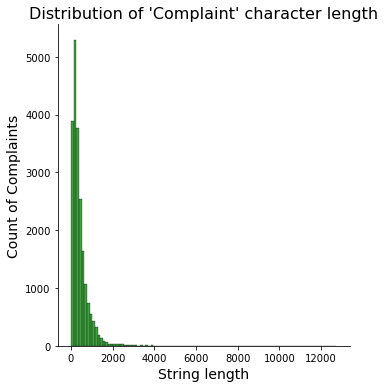

In [151]:
# Write your code here to visualise the data according to the 'Complaint' character length
str_len = [len(txt) for txt in df_clean.complaint_POS_removed]
sns.displot(str_len, kind='hist', bins=100,color='g')
plt.xlabel("String length", fontsize=14)
plt.ylabel("Count of Complaints", fontsize=14)
plt.title("Distribution of 'Complaint' character length", fontsize=16)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [152]:
# Importing Word cloud and stopword
from wordcloud import WordCloud, STOPWORDS

In [153]:
# Defining function for wordcloud generation
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

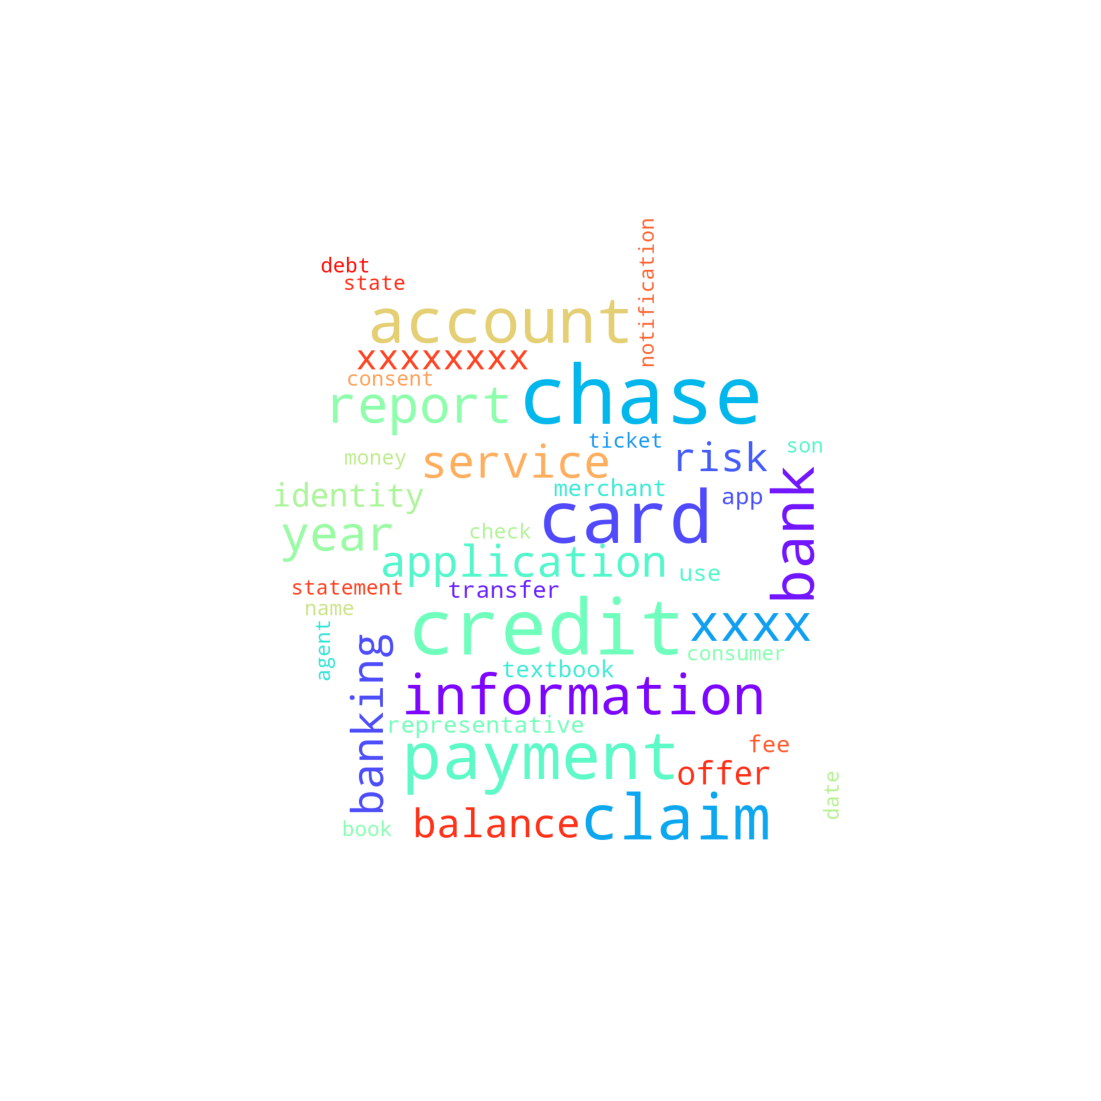

In [154]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Generate word cloud
mask = np.array(Image.open('Piggy_bank.jpg'))
wordcloud = WordCloud(width = 150, height = 100,mask=mask, random_state=100, background_color='white', max_font_size= 150,colormap='rainbow', collocations=False, max_words= 40, stopwords = STOPWORDS).generate(str(df_clean['complaint_POS_removed']))
# Plot
plot_cloud(wordcloud)

In [155]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [156]:
# Defining function to find the top ngrams - uni, bi and tri-grams
def top_ngrams(text, n=None, ngram=None):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [157]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigram = top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30_unigram, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,47488
1,chase,46548
2,xxxx,36538
3,credit,34141
4,card,29274
5,bank,28400
6,payment,21166
7,time,16022
8,charge,14993
9,check,13156


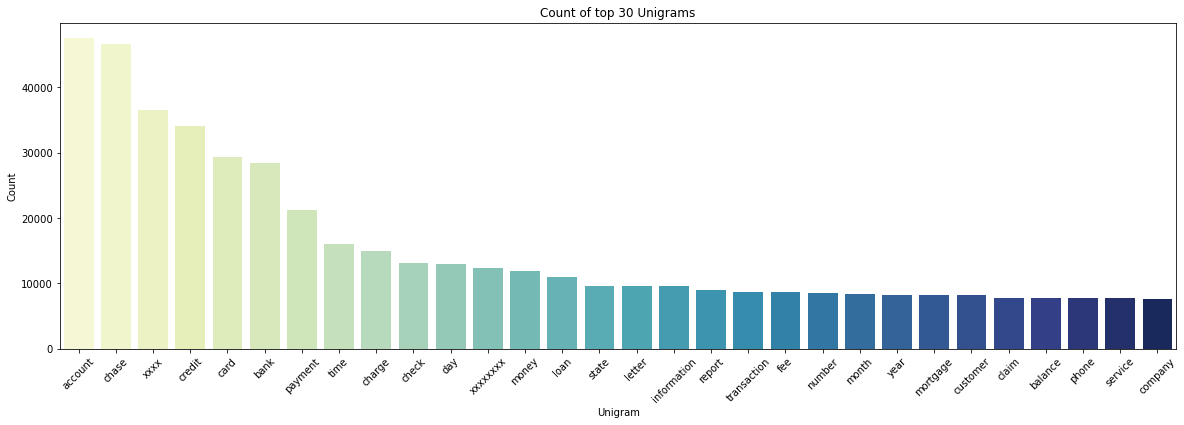

In [158]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'],palette= 'YlGnBu')
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [159]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47488
1,chase,46548
2,xxxx,36538
3,credit,34141
4,card,29274
5,bank,28400
6,payment,21166
7,time,16022
8,charge,14993
9,check,13156


In [160]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigram = top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30_bigram, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12777
1,credit report,3947
2,xxxx xxxx,3937
3,check account,3146
4,customer service,3081
5,chase credit,2962
6,chase bank,2936
7,bank account,2728
8,account chase,2579
9,account account,2357


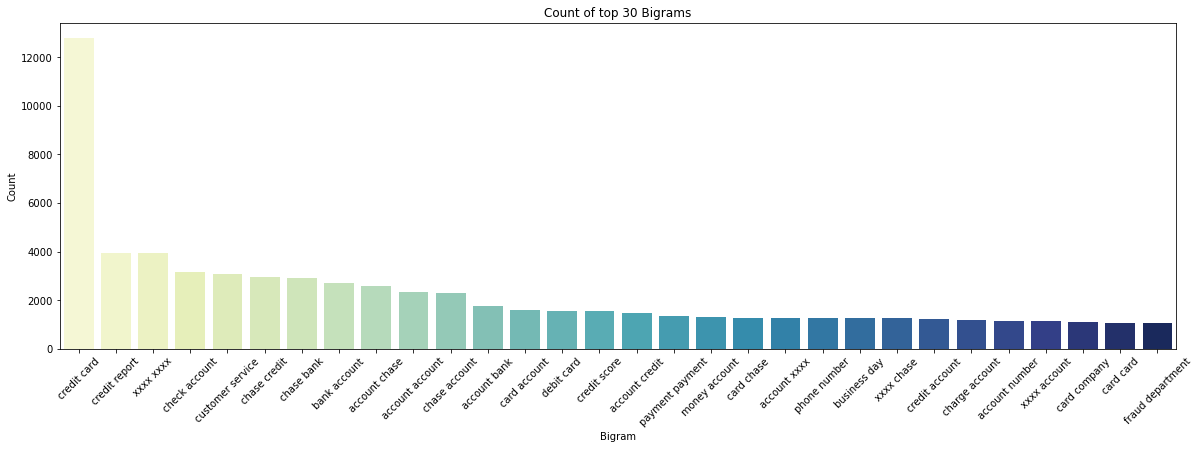

In [161]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'],palette= 'YlGnBu')
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [162]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12777
1,credit report,3947
2,xxxx xxxx,3937
3,check account,3146
4,customer service,3081
5,chase credit,2962
6,chase bank,2936
7,bank account,2728
8,account chase,2579
9,account account,2357


In [163]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigram = top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30_trigram, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2062
1,credit card account,1018
2,credit card company,991
3,credit card chase,630
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,423
7,xxxx xxxx xxxx,409
8,account credit card,398
9,card credit card,386


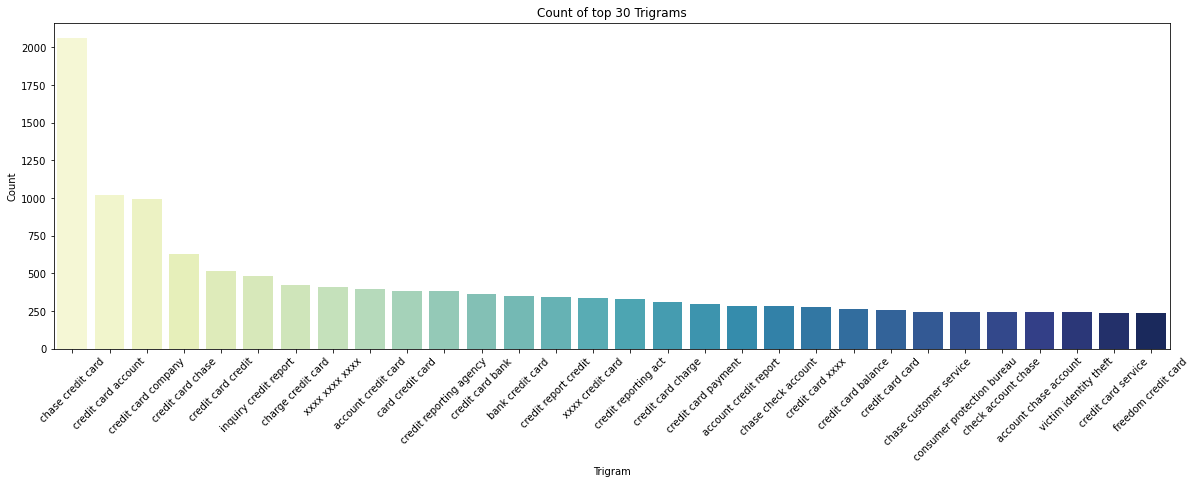

In [164]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'], palette= 'YlGnBu')
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [165]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2062
1,credit card account,1018
2,credit card company,991
3,credit card chase,630
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,423
7,xxxx xxxx xxxx,409
8,account credit card,398
9,card credit card,386


In [166]:
# Keeping a backup of the dataframe
df_clean_b = df_clean

In [167]:
# Defining functions to replace ngram words with one single word with '_' in between to consider it as a single character
def replaced_word(text):
    l1 =[]
    l1 = text.split()
    return '_'.join(l1)

In [168]:
# Defining functions to update the columns in the dataframe with the above logic
def update_ngamrs(ngram):
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace(ngram,replaced_word(ngram))

In [169]:
# Checking the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is no

In [170]:
# Applying functions to bigram words
for ngram in ['credit report','credit card','credit score','customer service','bank account']:
    update_ngamrs(ngram)

In [171]:
# Applying functions to trigram words
for ngram in ['consumer protection bureau','credit reporting agency']:
    update_ngamrs(ngram)

In [172]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is no

We can see that there are few bigrams and trigrams that have meaning only when used together for example Credit Card, Credit Score, consumer protection bureau. So we are going to join these words into one word using _, so that the model can identify the bigrams and trigrams as special to use together.

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [173]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [174]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being report

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [175]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [176]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
trm_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

In [177]:
# Let's check the matrix
trm_matrix

<21072x7266 sparse matrix of type '<class 'numpy.float64'>'
	with 643100 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [178]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [179]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =100
nmf_model = NMF(n_components=num_topics, random_state=100) #write your code here

In [180]:
nmf_model.fit(trm_matrix)
len(tfidf.get_feature_names())

7266

In [181]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'Top 15 words for topic #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for topic #0
['transfer', 'claim', 'bank_account', 'business', 'number', 'transaction', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


Top 15 words for topic #1
['year', 'credit_card', 'pay', 'chase', 'date', 'auto', 'time', 'account', 'day', 'credit', 'statement', 'fee', 'month', 'balance', 'payment']


Top 15 words for topic #2
['balance', 'claim', 'time', 'company', 'merchant', 'credit', 'fraud', 'purchase', 'transaction', 'fee', 'dispute', 'chase', 'credit_card', 'card', 'charge']


Top 15 words for topic #3
['credit_score', 'credit_reporting', 'bureaus', 'identity', 'debt', 'account', 'application', 'credit_card', 'information', 'card', 'company', 'report', 'credit', 'credit_report', 'inquiry']


Top 15 words for topic #4
['sale', 'foreclosure', 'house', 'document', 'time', 'rate', 'letter', 'bank', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




Looking at the topics above, we can assign a label based on their products/services:

- Topic 0 = Bank account services
- Topic 1 = Credit card / Prepaid card
- Topic 2 = Theft/Dispute reporting
- Topic 3 = Others
- Topic 4 = Mortgages/loans

In [182]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic = nmf_model.transform(trm_matrix)

In [183]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic.argmax(axis=1) #write your code to assign topics to each rows.

In [184]:
# Let's have a look at the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent,2
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,3
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now 

In [185]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,I open an account with chase bank on xxxx and use a code for xxxx bonus I call to follow up on xxxxxxxx about the term and be tell everything be on the account and once I make xxxx direct deposit the bonus would be pay out in day as of xxxx I have make the require deposit and be tell my account never have the coupon code apply and it be past the day to do so so no bonus would be pay,account bank code bonus term everything account deposit bonus day xxxx require deposit account coupon code apply day bonus,account bank code bonus term everything account deposit bonus day require deposit account coupon code apply day bonus,0
15,i opened the saving account for the bonus i was supposed to received the bonus after consecutive auto transfers from checking to savings i notice on that automatic transfer was cancelled for not enough funds into my checking s account therefore i put enough funds in my account on requested that the executive team reactivate my automatic transfer for the month of xxxx although ms xxxx reached out to me from the executive office she failed to try to resolve my concerns case xxxx,I open the saving account for the bonus I be suppose to received the bonus after consecutive auto transfer from check to saving I notice on that automatic transfer be cancel for not enough fund into my checking s account therefore I put enough fund in my account on request that the executive team reactivate my automatic transfer for the month of xxxx although ms xxxx reach out to I from the executive office she fail to try to resolve my concern case xxxx,account bonus bonus auto transfer check transfer fund account fund account request executive team transfer month executive office concern case xxxx,account bonus bonus auto transfer check transfer fund account fund account request executive team transfer month executive office concern case,0
4,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,son chase account fund bank_account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0
6,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer servic

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [186]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Theft/Dispute Reporting",
               3:"Others",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [187]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   lemmatized_complaint     21072 non-null  object
 2   complaint_POS_removed    21072 non-null  object
 3   Complaint_clean          21072 non-null  object
 4   Topic                    21072 non-null  object
dtypes: object(5)
memory usage: 823.2+ KB


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [188]:
#Create the dictionary again of Topic names and Topics

Topic_num = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Theft/Dispute Reporting":2,
               "Others":3,
               "Mortgage/Loan":4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_num)

In [189]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   lemmatized_complaint     21072 non-null  object
 2   complaint_POS_removed    21072 non-null  object
 3   Complaint_clean          21072 non-null  object
 4   Topic                    21072 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 823.2+ KB


In [190]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [191]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,2
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
4,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [192]:
#Checking training data
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [193]:
# Dataframe to check data distribution for each class
df_sam_num = training_data['Topic'].value_counts().reset_index()

In [194]:
df_sam_num['index'] = df_sam_num['index'].map(Topic_names)

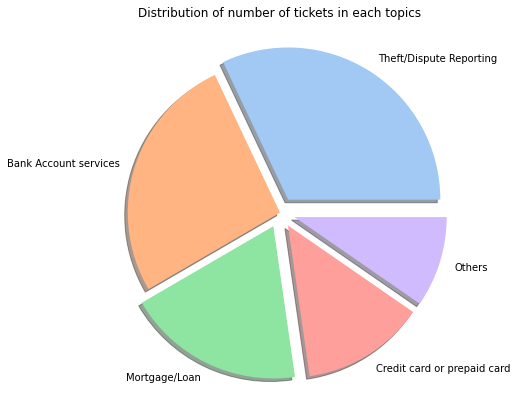

In [195]:
# Graph showing the total aount of investment in the four investment types
plt.figure(figsize=[7,7])
explode =(0.1,0,0.1,00.1,0.1) 
plt.pie(df_sam_num['Topic'],labels=df_sam_num['index'],explode = explode,shadow=True)
plt.title('Distribution of number of tickets in each topics')
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [196]:
#Write your code to get the Vector count
cv=CountVectorizer()
X_train_cv=cv.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf= TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_cv)

In [197]:
#Import libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score ,confusion_matrix,auc,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

In [198]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=100)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (16857, 33665)
y_train shape:  (16857,)
X_test shape:  (4215, 33665)
y_test shape:  (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Building models to automatically classify tickets

In [199]:
# Defining topic names
Topicnames = ["Bank account services", "Credit card / Prepaid card", "Theft/Dispute Reporting", "Others", "Mortgages/loans"]

In [200]:
# Defining function to Visualize Confusion Matrix with heatmap
def confusion_matrix2(x1,x2):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(x1, x2),
                 annot=True,
                 cbar=False,
                 cmap="GnBu", fmt = '0.1f')
    plt.xlabel("Actual label")
    plt.ylabel("Predicted label")
    plt.show()

### Model:1 - Logistic Regression

In [202]:
# Import library
from sklearn.linear_model import LogisticRegression

In [203]:
# Run the Logistic Regression model with default hyperparameters
lr = LogisticRegression(solver = 'liblinear',random_state=100) 
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

In [204]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_lr),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_lr),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_lr,average="weighted"),2))

Train Accuracy:- 0.95
Test Accuracy:- 0.91
Test F1 score:- 0.91


In [205]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_lr,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.90      0.94      0.92      1091
Credit card / Prepaid card       0.94      0.85      0.89       549
   Theft/Dispute Reporting       0.88      0.94      0.91      1336
                    Others       0.94      0.82      0.87       443
           Mortgages/loans       0.93      0.90      0.91       796

                  accuracy                           0.91      4215
                 macro avg       0.92      0.89      0.90      4215
              weighted avg       0.91      0.91      0.91      4215



**Observations:** We can see that the logictic regression model performed really well both on the training and test datasets with training accuracy of **95%** and test accuracy of **91%**. Let's use cross validation to improve model performance.

In [206]:
# Creating KFold object with 5 splits
import time
start_time = time.time()

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Specify params
params = {"C": np.arange(0.001, 100, 5)}


model_cv = GridSearchCV(estimator = LogisticRegression(solver = 'liblinear',random_state=100),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1) 

# Fit the model
model_cv.fit(X_train, y_train)
print("---Time taken %s seconds ---" % (time.time() - start_time))
print('Best Parameter :',model_cv.best_params_)
print('Best Score :',model_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


---Time taken 89.16239356994629 seconds ---
Best Parameter : {'C': 5.001}
Best Score : 0.9206855416357438


In [207]:
# Run the Logistic Regression model with optimal hyperparameters
lr = LogisticRegression(C=5.001, solver='liblinear',random_state=100) 
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

In [208]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_lr),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_lr),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_lr,average="weighted"),2))

Train Accuracy:- 0.99
Test Accuracy:- 0.92
Test F1 score:- 0.92


In [209]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_lr,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.91      0.94      0.93      1091
Credit card / Prepaid card       0.93      0.90      0.91       549
   Theft/Dispute Reporting       0.91      0.94      0.92      1336
                    Others       0.94      0.85      0.89       443
           Mortgages/loans       0.94      0.91      0.92       796

                  accuracy                           0.92      4215
                 macro avg       0.93      0.91      0.92      4215
              weighted avg       0.92      0.92      0.92      4215



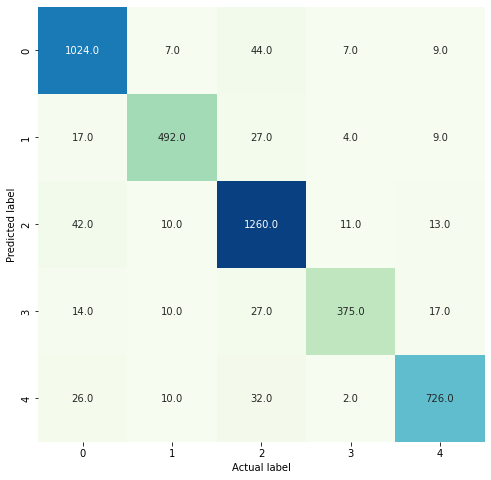

In [210]:
confusion_matrix2(y_test, y_test_pred_lr)

**Observations:** We can see that the logictic regression model performed really well with cross validation both on the training and test datasets with training accuracy of **99%** and test accuracy of **92%**.

### Model:2 - Decision Tree

In [211]:
# Import library
from sklearn.tree import DecisionTreeClassifier

In [212]:
# Run the Decision Tree model with default hyperparameters
dt = DecisionTreeClassifier(random_state=100) 
dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

In [213]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_dt),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_dt),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_dt,average="weighted"),2))

Train Accuracy:- 1.0
Test Accuracy:- 0.78
Test F1 score:- 0.78


In [214]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_dt,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.80      0.78      0.79      1091
Credit card / Prepaid card       0.73      0.77      0.75       549
   Theft/Dispute Reporting       0.79      0.81      0.80      1336
                    Others       0.74      0.71      0.72       443
           Mortgages/loans       0.79      0.77      0.78       796

                  accuracy                           0.78      4215
                 macro avg       0.77      0.77      0.77      4215
              weighted avg       0.78      0.78      0.78      4215



**Observations:** We can see that the Decision Tree model performed well but overfitted the training data with training accuracy of **100%** and test accuracy of **78%**. Let's use cross validation to improve model performance.

In [215]:
# Creating KFold object with 5 splits
import time
start_time = time.time()

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Specify params
params = {"max_depth": np.arange(5, 50, 5),
           "min_samples_split": np.arange(10, 40, 5),
           "min_samples_leaf": np.arange(10, 40, 5)}


model_cv = GridSearchCV(estimator = DecisionTreeClassifier(random_state=100),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1) 

# Fit the model
model_cv.fit(X_train, y_train)
print("---Time taken %s seconds ---" % (time.time() - start_time))
print('Best Parameter :',model_cv.best_params_)
print('Best Score :',model_cv.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  9.7min finished


---Time taken 588.706063747406 seconds ---
Best Parameter : {'max_depth': 35, 'min_samples_leaf': 10, 'min_samples_split': 35}
Best Score : 0.8094559590506283


In [217]:
# Run the Decision Tree model with optimal hyperparameters
dt = DecisionTreeClassifier(max_depth = 35, min_samples_leaf=10, min_samples_split=35, random_state=100) 
dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

In [218]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_dt),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_dt),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_dt,average="weighted"),2))

Train Accuracy:- 0.88
Test Accuracy:- 0.79
Test F1 score:- 0.79


In [219]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_dt,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.81      0.81      0.81      1091
Credit card / Prepaid card       0.77      0.80      0.78       549
   Theft/Dispute Reporting       0.79      0.82      0.80      1336
                    Others       0.76      0.69      0.72       443
           Mortgages/loans       0.81      0.78      0.79       796

                  accuracy                           0.79      4215
                 macro avg       0.79      0.78      0.78      4215
              weighted avg       0.79      0.79      0.79      4215



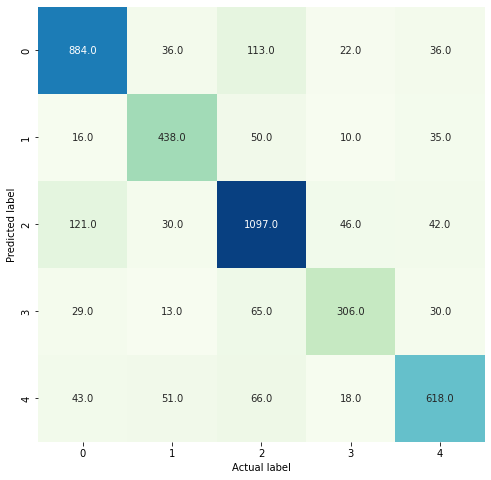

In [220]:
confusion_matrix2(y_test, y_test_pred_dt)

**Observations:** We can see that the Decision Tree model performed well with cross validation both on the training and test datasets with training accuracy of **88%** and test accuracy of **79%**.

### Model:3 - Random Forest

In [221]:
# Import library
from sklearn.ensemble import RandomForestClassifier

In [222]:
# Run the Decision Tree model with default hyperparameters
rf = RandomForestClassifier(random_state=100) 
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [223]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_rf),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_rf),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_rf,average="weighted"),2))

Train Accuracy:- 1.0
Test Accuracy:- 0.81
Test F1 score:- 0.8


In [224]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_rf,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.80      0.87      0.84      1091
Credit card / Prepaid card       0.89      0.50      0.64       549
   Theft/Dispute Reporting       0.75      0.92      0.82      1336
                    Others       0.89      0.65      0.75       443
           Mortgages/loans       0.89      0.83      0.86       796

                  accuracy                           0.81      4215
                 macro avg       0.84      0.76      0.78      4215
              weighted avg       0.82      0.81      0.80      4215



**Observations:** We can see that the Random forest model performed well but overfitted the training dataset with training accuracy of **100%** and test accuracy of **81%**. Let's use cross validation to improve model performance.

In [225]:
# Creating KFold object with 5 splits
import time
start_time = time.time()

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Specify params
params = {"max_depth": np.arange(40, 50, 2),
           "min_samples_split": np.arange(5, 10, 2),
           "min_samples_leaf": np.arange(5, 20, 5),
           'n_estimators': np.arange(100, 300, 50), 
           }


model_cv = GridSearchCV(estimator = RandomForestClassifier(random_state=100),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1) 

# Fit the model
model_cv.fit(X_train, y_train)
print("---Time taken %s seconds ---" % (time.time() - start_time))
print('Best Parameter :',model_cv.best_params_)
print('Best Score :',model_cv.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 24.3min finished


---Time taken 1489.8250420093536 seconds ---
Best Parameter : {'max_depth': 48, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 250}
Best Score : 0.7950997324538761


In [226]:
# Run the Decision Tree model with optimal hyperparameters
rf = RandomForestClassifier(max_depth= 48, min_samples_leaf= 5, min_samples_split= 5,n_estimators=250, random_state=100) 
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [227]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_rf),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_rf),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_rf,average="weighted"),2))

Train Accuracy:- 0.9
Test Accuracy:- 0.79
Test F1 score:- 0.78


In [228]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_rf,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.81      0.87      0.84      1091
Credit card / Prepaid card       0.93      0.39      0.55       549
   Theft/Dispute Reporting       0.71      0.94      0.81      1336
                    Others       0.92      0.58      0.71       443
           Mortgages/loans       0.87      0.83      0.85       796

                  accuracy                           0.79      4215
                 macro avg       0.85      0.72      0.75      4215
              weighted avg       0.82      0.79      0.78      4215



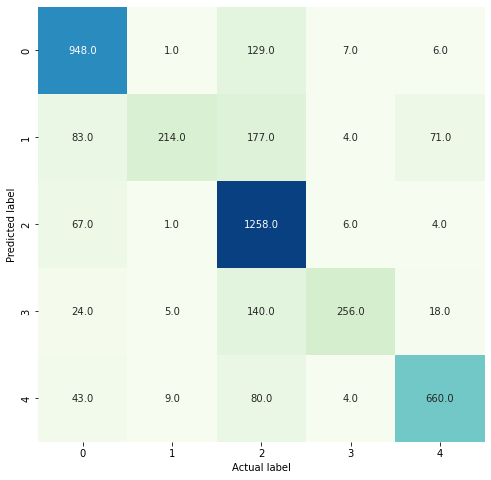

In [229]:
confusion_matrix2(y_test, y_test_pred_rf)

**Observations:** We can see that the Random forest model performed well with cross validation both on the training and test datasets with training accuracy of **90%** and test accuracy of **79%**.

### Model:4 - Naive Bayes

In [230]:
# Import library
from sklearn.naive_bayes import MultinomialNB

In [231]:
# Run the Decision Tree model with default hyperparameters
nb = MultinomialNB() 
nb.fit(X_train, y_train)

y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb = nb.predict(X_test)

In [232]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_nb),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_nb),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_nb,average="weighted"),2))

Train Accuracy:- 0.68
Test Accuracy:- 0.64
Test F1 score:- 0.59


In [233]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_nb,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.84      0.75      0.79      1091
Credit card / Prepaid card       0.96      0.04      0.08       549
   Theft/Dispute Reporting       0.50      0.96      0.66      1336
                    Others       0.98      0.12      0.21       443
           Mortgages/loans       0.89      0.66      0.76       796

                  accuracy                           0.64      4215
                 macro avg       0.83      0.51      0.50      4215
              weighted avg       0.77      0.64      0.59      4215



**Observations:** We can see that the Naive Bayes model performed poorly with respect to the other models with training accuracy of **68%** and test accuracy of **64%**. Let's use cross validation to improve model performance.

In [247]:
# Creating KFold object with 5 splits
import time
start_time = time.time()

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Specify params
params = {'alpha': (1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001),
          'fit_prior':[True, False]}


model_cv = GridSearchCV(estimator = MultinomialNB(),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1) 

# Fit the model
model_cv.fit(X_train, y_train)
print("---Time taken %s seconds ---" % (time.time() - start_time))
print('Best Parameter :',model_cv.best_params_)
print('Best Score :',model_cv.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s


---Time taken 1.0651373863220215 seconds ---
Best Parameter : {'alpha': 0.1, 'fit_prior': False}
Best Score : 0.7881590694194746


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


In [248]:
# Run the Decision Tree model with optimal hyperparameters
nb = MultinomialNB(alpha = 0.1, fit_prior=False) 
nb.fit(X_train, y_train)

y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb = nb.predict(X_test)

In [249]:
# Calculating accuracy
print("Train Accuracy:-",round(accuracy_score(y_train, y_train_pred_nb),2))
print("Test Accuracy:-",round(accuracy_score(y_test, y_test_pred_nb),2))
print("Test F1 score:-",round(f1_score(y_test, y_test_pred_nb,average="weighted"),2))

Train Accuracy:- 0.87
Test Accuracy:- 0.79
Test F1 score:- 0.79


In [250]:
print('Classification Report: ')
print(classification_report(y_test, y_test_pred_nb,target_names = Topicnames))

Classification Report: 
                            precision    recall  f1-score   support

     Bank account services       0.77      0.85      0.81      1091
Credit card / Prepaid card       0.67      0.66      0.67       549
   Theft/Dispute Reporting       0.84      0.78      0.81      1336
                    Others       0.75      0.75      0.75       443
           Mortgages/loans       0.83      0.82      0.83       796

                  accuracy                           0.79      4215
                 macro avg       0.77      0.77      0.77      4215
              weighted avg       0.79      0.79      0.79      4215



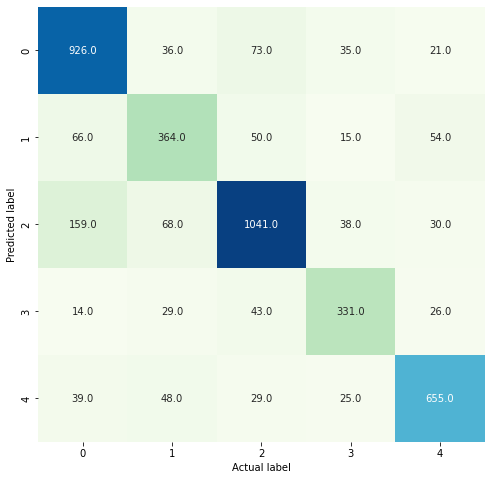

In [251]:
confusion_matrix2(y_test, y_test_pred_nb)

**Observations:** We can see that the Naive Bayes model performed better with cross validation both on the training and test datasets with training accuracy of **87%** and test accuracy of **79%**. 

#### Model evaluation:

We tried four types of machine learning algorythms - Logistic regression, Decision Trees, Random Forests and Naive Bayes. The best results were shown by Logistic regression with an accuracy of **99%** on the training data and **92%** on the test dataset.

Let's have a look at the model performances in the figure below:

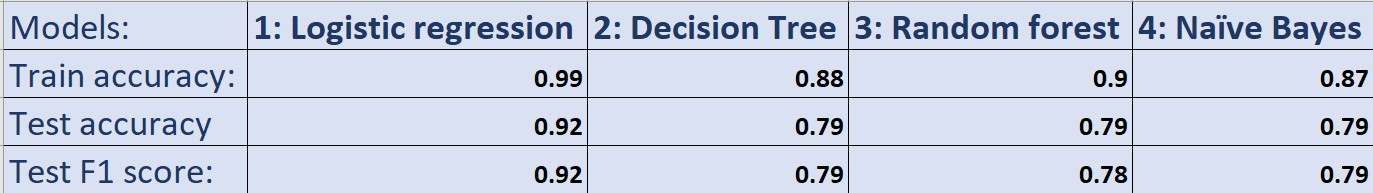

### Model performance on unseen test data:

Let's check the model performance on unseen data and observe if the model is able to classify correctly

In [281]:
# Creating dummy custom data
df_testdata = pd.DataFrame({'complaint_what_happened': ["Can I get the transaction details of my bank account with all the details of transfer and deposits from first day of this month?",
                                  "I want to know if there is any foreclosure charges for my home loan account that is with your bank if I close it within three years of application.",                         
                                  "I received a text stating that my card was used to purchase a product that I am not aware of. I want to bring this to your kind attention that my card is being used by someone and I am not aware of the situation."
                                  ]})

In [282]:
# Converting to Vector
df_testdata_cv=cv.transform(df_testdata['complaint_what_happened'])

#Transform the word vector to tf-idf
X_testdata_tfidf = tfidf.transform(df_testdata_cv)

In [283]:
#Predicting topic using logistic regression model
y_testdata_pred = lr.predict(X_testdata_tfidf)

In [284]:
# Converting y_testdata_pred to a dataframe which is an array
y_testdata_pred = pd.DataFrame(y_testdata_pred)

In [285]:
# Appending y_pred and df_testdata
y_pred = pd.concat([df_testdata, y_testdata_pred],axis=1)
# Renaming the column 
y_pred= y_pred.rename(columns={ 0 : 'Predicted_Topic'})

In [286]:
#Replace Topics with Topic Names
y_pred['Predicted_Topic'] = y_pred['Predicted_Topic'].map(Topic_names)

In [287]:
# Checking the results
y_pred

,complaint_what_happened,Predicted_Topic
0,Can I get the transaction details of my bank account with all the details of transfer and deposits from first day of this month?,Bank Account services
1,I want to know if there is any foreclosure charges for my home loan account that is with your bank if I close it within three years of application.,Mortgage/Loan
2,I received a text stating that my card was used to purchase a product that I am not aware of. I want to bring this to your kind attention that my card is being used by someone and I am not aware of the situation.,Theft/Dispute Reporting


**Conclusion:** So we can conclude that the logistic regression model is performing well on unseen data as well. We can be confident that the model will work well on other data as well.